In [1]:
import pandas as np
import pandahouse as ph
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy import stats
import seaborn as sns

присоединяемся к базе данных и отправляем запрос

In [2]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'simulator',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
query = '''
SELECT post_id,
       time,
       user_id,
       action
FROM {db}.feed_actions
WHERE (toDate(time) > today()-7) and action = 'view'
'''

In [4]:
df = ph.read_clickhouse(query, connection=connection)
df

,post_id,time,user_id,action
0,2530,2021-11-22 23:23:21,120095,view
1,2501,2021-11-22 23:23:21,127191,view
2,2594,2021-11-22 23:23:21,128836,view
3,2531,2021-11-22 23:23:21,133911,view
4,2616,2021-11-22 23:23:21,136841,view
...,...,...,...,...
3842983,2510,2021-11-22 23:23:21,30551,view
3842984,2329,2021-11-22 23:23:21,31483,view
3842985,2520,2021-11-22 23:23:21,31483,view
3842986,2569,2021-11-22 23:23:21,34231,view


создаем новую табличку только с нужными нам полями

In [5]:
df_unique_post = df[['post_id','time','action']]

добавляем колонку с временем, когда пост появился первый раз

In [6]:
df_unique_post = df_unique_post.merge(df_unique_post.groupby('post_id', as_index=False)\
                                      .min().drop('action', axis=1),left_on='post_id', right_on='post_id',how='left')\
                                        .rename(columns={'time_x':'time','time_y':'min_time'})

In [7]:
df_unique_post.head()

,post_id,time,action,min_time
0,2530,2021-11-22 23:23:21,view,2021-11-21 23:40:07
1,2501,2021-11-22 23:23:21,view,2021-11-21 00:00:15
2,2594,2021-11-22 23:23:21,view,2021-11-22 17:03:51
3,2531,2021-11-22 23:23:21,view,2021-11-21 23:18:42
4,2616,2021-11-22 23:23:21,view,2021-11-22 22:45:00


переводим дельтатайм в секунды

In [8]:
df_unique_post['lifetime'] = (df_unique_post.time - df_unique_post.min_time).apply(lambda x: x.total_seconds())

In [9]:
df_unique_post.head()

,post_id,time,action,min_time,lifetime
0,2530,2021-11-22 23:23:21,view,2021-11-21 23:40:07,85394.0
1,2501,2021-11-22 23:23:21,view,2021-11-21 00:00:15,170586.0
2,2594,2021-11-22 23:23:21,view,2021-11-22 17:03:51,22770.0
3,2531,2021-11-22 23:23:21,view,2021-11-21 23:18:42,86679.0
4,2616,2021-11-22 23:23:21,view,2021-11-22 22:45:00,2301.0


визуализируем

array([[<AxesSubplot:title={'center':'lifetime'}>]], dtype=object)

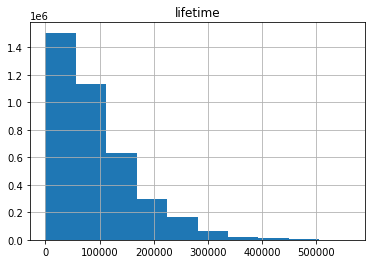

In [10]:
df_unique_post.hist('lifetime')